In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import re
from collections import defaultdict
import glob
from datetime import datetime
import pickle

np.random.seed(1234)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
sns.set_style('darkgrid')

%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F

In [3]:
torch.manual_seed(1234)

In [4]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(torch.__version__)

0.4.0


In [6]:
class Vocab:
    def __init__(self):
        self.word2index = defaultdict(int)
        self.word2count = defaultdict(int)
        self.index2word = defaultdict(str)
        self.n_words = 0
    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word)
    
    def add_word(self, word):
        # 注意!!!!!!!!
        # 語彙に対して1からラベルを振っているので、ラベルの最大値のindexは語彙数
        # pythonのindexは0からスタートなので、nn.Embeddingは語彙数+1を指定する必要あり
        # 普通に0からラベル貼ろうか
        # defaultdictなので、間違って未知のkeyを作成してvalue0を増やさないようにする
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
%%time
vocab = Vocab()

for path in glob.glob('../preprocessed/*.csv'):
    series = pd.read_csv(path, header=None, dtype={0: str}, encoding='utf-8').dropna(axis=0)[0]
    for sentence in series:
        vocab.add_sentence(sentence)

# defaultdictは未知のkeyに対応するvalueを要求すると、defaultのvalueを作成してしまう
# 後々のバグを防ぐため、通常のdictに変えてロックする
vocab.word2index = dict(vocab.word2index)
vocab.index2word = dict(vocab.index2word)
vocab.word2count = dict(vocab.word2count)

CPU times: user 696 ms, sys: 12 ms, total: 708 ms
Wall time: 708 ms


In [8]:
def make_padded_array(reviews, vocab=vocab):  
    review_list = list()
    len_list = list()
    for r in reviews:
        r = str(r)
        review_indexes = [vocab.word2index[w] for w in r.split()]
        review_list.append(review_indexes)
        len_list.append(len(review_indexes))
    
    len_array = np.sort(len_list)[::-1].copy() # torch.Tensorは配列逆にしているとエラーを起こすので、コピーする
    idxes = np.argsort(len_list)[::-1].copy()
    text_array = np.zeros((len(review_list), max(len_list)), dtype=int)
    for i, idx in enumerate(idxes):
        text_array[i, :len(review_list[idx])] = review_list[idx]
    return text_array, len_array, idxes + reviews.index[0] # idxesは0スタートなので、入力reviewsのindexと一致するように調整する

In [9]:
class BatchIterator(object):
    def __init__(self, df, batch_len, is_shuffle=True):
        self.df = df
        self.batch_len = batch_len
        self.n_batch = df.shape[0] // batch_len + 1
        self.n_data = df.shape[0]
        self.is_shuffle = is_shuffle
    
    def __iter__(self):
        if self.is_shuffle:
            df = self.df.sample(frac=1).reset_index(drop=True) # DFをシャッフルする
        else:
            df = self.df
        for b_idx in range(0, self.df.shape[0], self.batch_len):
            text_batch = df.loc[b_idx:b_idx+self.batch_len-1, "text"]
            target_batch = df.loc[b_idx:b_idx+self.batch_len-1, "label"]
            
            text_array, len_array, idxes = make_padded_array(text_batch)
            target_array = target_batch[idxes].values
            
            text_tensor = torch.LongTensor(text_array).to(device)
            lengths_tensor = torch.LongTensor(len_array).to(device)
            target_tensor = torch.LongTensor(target_array).to(device)
            
            yield text_tensor, lengths_tensor, target_tensor

やること  

単一カテゴリのtrain_dataとtest_dataを作成(ダウンサンプリング)  
LSTMモデルを作成(Attention無し)  
学習、性能評価(仮の)  

将来的には、モデルの作成・保存とモデルの呼び出し・学習・評価を分離した方が良い

# データの作成

多値分類のデータセットを作る  
クラスを0~5に降る

In [10]:
vg_train = pd.read_csv('../preprocessed/vg_train.csv', header=None, encoding='utf-8')
hk_train = pd.read_csv('../preprocessed/hk_train.csv', header=None, encoding='utf-8')
so_train = pd.read_csv('../preprocessed/so_train.csv', header=None, encoding='utf-8')
csj_train = pd.read_csv('../preprocessed/csj_train.csv', header=None, encoding='utf-8')
hpc_train = pd.read_csv('../preprocessed/hpc_train.csv', header=None, encoding='utf-8')
aa_train = pd.read_csv('../preprocessed/aa_train.csv', header=None, encoding='utf-8')

In [11]:
for df in [vg_train, hk_train, so_train, csj_train, hpc_train, aa_train]:
    print(df.shape)

(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)


In [12]:
train_data = pd.concat([vg_train, hk_train, so_train, csj_train, hpc_train, aa_train], axis=0).reset_index(drop=True)

In [13]:
i = 10000
train_data['label'] = pd.Series([0]*i+[1]*i+[2]*i+[3]*i+[4]*i+[5]*i)

In [14]:
train_data = train_data.sample(frac=1).reset_index(drop=True)

In [15]:
train_data.columns = ['text', 'label']

In [16]:
train_data.shape

(6000, 2)

In [17]:
train_data.head()

,text,label
0,because of its compactness my bike lover can a...,0
1,not much to say after all it is a rail and wor...,0
2,this app does what it is supposed to do with o...,0
3,our old ironing board cover was very thin to b...,0
4,i bought these for my year old son they fit gr...,0


In [18]:
vg_test = pd.read_csv('../preprocessed/vg_test.csv', header=None, encoding='utf-8')
hk_test = pd.read_csv('../preprocessed/hk_test.csv', header=None, encoding='utf-8')
so_test = pd.read_csv('../preprocessed/so_test.csv', header=None, encoding='utf-8')
csj_test = pd.read_csv('../preprocessed/csj_test.csv', header=None, encoding='utf-8')
hpc_test = pd.read_csv('../preprocessed/hpc_test.csv', header=None, encoding='utf-8')
aa_test = pd.read_csv('../preprocessed/aa_test.csv', header=None, encoding='utf-8')

test_data = pd.concat([vg_test, hk_test, so_test, csj_test, hpc_test, aa_test], axis=0).reset_index(drop=True)

i = 10000
test_data['label'] = pd.Series([0]*i+[1]*i+[2]*i+[3]*i+[4]*i+[5]*i)
test_data = test_data.sample(frac=1).reset_index(drop=True)
test_data.columns = ['text', 'label']

In [19]:
%%time
text_iterator = BatchIterator(train_data, 1)
cnt = 0
for te, l, ta in text_iterator:
    cnt += 1

CPU times: user 5.44 s, sys: 0 ns, total: 5.44 s
Wall time: 5.43 s


# モデルの作成

基本的にここに準拠  
https://qiita.com/itok_msi/items/ad95425b6773985ef959

Embedding(146467→100)  
LSTM(100→32)  
Attention  
MLP(32→1)  

Target(2), neg→[1,0], pos→[0,1]  

損失関数に binary_cross_entropy_with_logits を噛ませるので、モデルの出力を[0,1]に制限しなくても良い(sigmoidとlossを別にするより学習が安定する)  
予測時には出力層にsigmoid関数を噛ませる

## Attention無しのbiLSTM

In [20]:
# pack_padded_sequnceを用いた実装
class LSTMClassifer(nn.Module):
    def __init__(self, emb_dim, h_dim, v_size, n_class=2, bidirectional=True,
                 batch_first=True):
        super(LSTMClassifer, self).__init__()
        self.h_dim = h_dim
        self.bi = 2 if bidirectional else 1
        self.emb = nn.Embedding(v_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, h_dim, batch_first=batch_first, 
                            bidirectional = bidirectional)
        self.affine = nn.Linear(self.h_dim * self.bi, n_class)
        
    def init_hidden(self, b_size):
        h0 = torch.zeros(self.bi, b_size, self.h_dim, device=device)
        return (h0, h0) # LSTMはhiddenとcell2つの隠れ層が必要
    
    def forward(self, sentences, lengths):
        hidden, cell = self.init_hidden(sentences.shape[0])
        embed = self.emb(sentences)
        packed_input = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True)
        output, hidden = self.lstm(packed_input, (hidden, cell))
        output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)[0]
        
        f_out = output[:, -1, :self.h_dim]
        r_out = output[:, 0, self.h_dim:]
        output = torch.cat((f_out, r_out), dim=1)
        
        output = self.affine(output)
        output = F.log_softmax(output, dim=1) # (b, n_class), 各データが各クラスに属した場合の対数尤度を計算
        return output

In [21]:
model = LSTMClassifer(100, 32, vocab.n_words, 6, False).to(device)

In [30]:
class LSTMClassifer2(nn.Module):
    def __init__(self, emb_dim, h_dim, v_size, n_class=2, bidirectional=True,
                 batch_first=True):
        super(LSTMClassifer2, self).__init__()
        self.h_dim = h_dim
        self.bi = 2 if bidirectional else 1
        self.emb = nn.Embedding(v_size, emb_dim)
        self.flstm = nn.LSTM(emb_dim, h_dim, batch_first=batch_first, 
                            bidirectional = False)
        self.blstm = nn.LSTM(emb_dim, h_dim, batch_first=batch_first, 
                            bidirectional = False)
        self.affine = nn.Linear(self.h_dim * self.bi, n_class)
        
    def init_hidden(self, b_size):
        h0 = torch.zeros(1, b_size, self.h_dim, device=device)
        return (h0, h0) # LSTMはhiddenとcell2つの隠れ層が必要
    
    def forward(self, sentences, l):
        hidden, cell = self.init_hidden(sentences.shape[0])
        embed = self.emb(sentences)
        fout, (fhidden, fcell) = self.flstm(embed[:,0,:].unsqueeze(1), (hidden, cell))
        bout, (bhidden, bcell) = self.blstm(embed[:,-1,:].unsqueeze(1), (hidden, cell))
        for i in range(sentences.shape[1]-1):
            fout, (fhidden, fcelll) = self.flstm(embed[:,i+1,:].unsqueeze(1), (fhidden, fcell))
            bout, (bhidden, bcell) = self.blstm(embed[:,-i-2,:].unsqueeze(1), (bhidden, fcell))
        
        output = torch.cat((fout, bout), dim=2).squeeze(0)
        
        output = self.affine(output)
        output = F.log_softmax(output, dim=1) # (b, n_class), 各データが各クラスに属した場合の対数尤度を計算
        return output

# 学習関数の設定

In [31]:
def train_model(epoch, train_iter, optimizer, log_interval=100):
    model.train()
    correct = 0
    all_ = 0
    epoch_loss = 0
    epoch_ac = 0
    
    for idx, (x, x_l, y) in enumerate(train_iter):
        optimizer.zero_grad()
        output = model(x, x_l)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        pred = output.data.max(dim=1)[1]
        correct += pred.eq(y).sum().item() # 予測と実測の正答数を加算
        epoch_ac += pred.eq(y).sum().item()
        all_ += len(y)
     
        if idx % log_interval == 0:
            # バッチ毎の更新で十分にaccuracyが上がっていくので、そこの進捗を表示する
            print('time {}, train epoch: {} [{}/{}], acc:{:.4f}, loss:{:.4f}'.format(
                datetime.now() - start, epoch, idx+1, train_iter.n_batch, correct/all_, loss))
            correct = 0
            all_ = 0
    return epoch_loss / idx+1, epoch_ac/train_iter.n_data

In [32]:
def test_model(epoch, test_iter, log_interval=5):
    model.eval()
    with torch.no_grad():
        correct = 0
        epoch_loss = 0
        epoch_ac = 0
        for idx, (x, x_l, y) in enumerate(test_iter):
            output = model(x, x_l)
            loss = F.nll_loss(output, y)
            epoch_loss += loss.item()
            
            pred = output.data.max(dim=1)[1]
            correct += pred.eq(y).sum().item()
            epoch_ac += pred.eq(y).sum().item()
            
    if epoch % log_interval == 0:
        print('time {}, test epoch: {}, acc:{:.4f}, loss:{:.4f}'.format(
        datetime.now() - start, epoch, correct/test_iter.n_data, loss))
    return epoch_loss / idx+1, epoch_ac/test_iter.n_data

In [33]:
def predict_model(review):
    review_idxes = [vocab.word2index[w] for w in str(review).split()]
    review_tensor = torch.LongTensor(review_idxes).to(device).unsqueeze(0)
    length_tensor = torch.LongTensor([len(review_idxes)]).to(device)
    
    return model(review_tensor, length_tensor).data.max(dim=1)[1].item()

# 学習の実行

In [34]:
model = LSTMClassifer2(100, 32, vocab.n_words, n_class=6).to(device)

In [35]:
train_iter = BatchIterator(train_data, batch_len=1, is_shuffle=False)
test_iter = BatchIterator(test_data, batch_len=1, is_shuffle=False)

In [36]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
patience = 1
n_epoch = 10

In [37]:
%%time
train_lc = []
test_lc = []
train_acc = []
test_acc = []
cnt = 0
start = datetime.now()
for epoch in range(n_epoch):
    train_loss, train_ac = train_model(epoch, test_iter, optimizer, log_interval=1000) # 学習が高速に進む+iter時間かかる→batch毎に進捗プリント
    train_lc.append(train_loss)
    train_acc.append(train_ac)
    
    test_loss, test_ac = test_model(epoch, train_iter, log_interval=1)
    test_lc.append(test_loss)
    test_acc.append(test_ac)
    
    if epoch > 0:
        if test_loss >= min(test_lc[:-1]):
            cnt += 1
        else:
            cnt = 0
    
    if cnt >= patience:
            print('early stopping: epoch {}'.format(epoch))
            break
    
print("Done !")

time 0:00:00.192081, train epoch: 0 [1/6001], acc:0.0000, loss:1.7304
time 0:04:18.140005, train epoch: 0 [1001/6001], acc:0.9820, loss:0.0004


KeyboardInterrupt: 

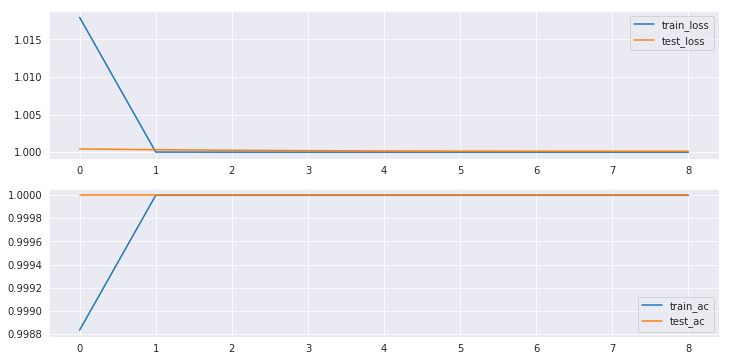

In [32]:
fig, axes = plt.subplots(nrows=2, figsize=(12,6))
axes[0].plot(train_lc, label='train_loss')
axes[0].plot(test_lc, label='test_loss')
axes[1].plot(train_acc, label='train_ac')
axes[1].plot(test_acc, label='test_ac')
axes[0].legend()
axes[1].legend()
plt.show()

In [33]:
# torch.save(model.state_dict(), "../output/bilstm_params.pickle")

In [35]:
# pickle.dump([train_loss, test_loss, train_acc, test_acc], open('../output/pytorch_bilstm_metrics.pickle', mode='wb'))